Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Overview

This notebook contains datasets for the paper:  ["Intuitive Physics Learning in a deep-learning model inspired by developmental psychology"](LINK_TBD).  Below we recap some of the details listed in the manuscript.

There are two categories of datasets:
1. The `freeform` category contains videos of unstructured physical events. It contains a training set (300,000 videos) and a test set (5,000 videos). The freeform dataset is suitable for training a model.  This dataset contains a _moving camera_ which always starts at the same location and then randomly moves throught out the video.
2. The `probe` category contains five datasets designed to probe one of the five physical concepts listed below.  Please see the accompanying paper for an in-depth explanation of these physical concepts.Each probe dataset consists of 5,000 `probe quadruplets`. Each quadruplet consists of four videos. The probe datasets are not necessarily suitable for training a model. The probe datasets always use a _static camera_.
 - Continuity
 - Solidity
 - Object Persistence
 - "Unchangeablesness"
 - Directional Inertia

For all datasets, the data consist of videos spanning 15 frames and rendered at a resolution of 64x64 pixels with 3 RGB channels. Each video contains the following keys:
* `image`: rendered image. `(shape: 15, 64, 64, 3)`
* `mask`: object segmentation mask, containing a maximum of 8 unique integers corresponding to the ith object mask `(shape: 15, 64, 64)`
* `camera_pose`: camera orientation and position per frame specified as 6 values `(shape: 15, 6)`:
  *  lookat (x, y, z)
  * distance
  * azimuth
  * elevation

NOTE: The probe datasets make the above keys available as `possible_*` and `impossible_*` e.g. `possible_image` or `possible_mask`.

### Probe Quadruplets

Each probe quadruplet consists of four related videos relevant for testing a physical concept:
* two physically possible videos
* two physically impossible videos

As such, probes contain the following keys:
* `possible_image (shape: 2, 15, 64, 64, 3)`
* `possible_mask (shape: 2, 15, 64, 64)`
* `possible_camera_pose (shape: 2, 15, 6)`
* `impossible_image (shape: 2, 15, 64, 64, 3)`
* `impossible_mask (shape: 2, 15, 64, 64)`
* `impossible_camera_pose (shape: 2, 15, 6)`

### Freeform Data

This data consists of randomly generated scenes of physical events in the service of training models to learn physics.  In order to produce eventful physical interactions, we built _composable_ "__scene building blocks__."  Each scene consisted of 2-4 scene building blocks (__SBBs__).


The building block types are listed below:
* rolling 
* collisions along the ground plane
* throwing an object onto the scene
* dropping an object onto the scene
* occlusions (via a "curtain" that descends from the top of the screen and retracts)
* placing object stacks in the scene
* covering interactions (an open-bottom, closed-top container falls onto an object)
* containment events (an object falls into an open-top container)
* rolling up/down ramps

Each building block uses randomly generated values for object appearances and locations, while ensuring the main intended physical interaction still occurred. SBBs interacted via locations.  The first SBB added to a scene generates object parameters independently.  The next SBB added to a scene could choose (depending on its type) its object parameters either independently OR in a manner that would "target" the objects added from previous SBBs.  For example, a throwing SBB could choose where to throw the object either independently or at an object that has already been added to the scene.  This is what we mean when we say our SBBs composed with each other to produce eventful scenes.


In [ ]:
#@title Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf


from google.colab import auth
auth.authenticate_user()

In [ ]:
#@title Dataset Constants
_NUM_PROBE_TFRECORDS = 20
_NUM_FREEFORM_TRAIN_TFRECORDS = 100
_NUM_FREEFORM_TEST_TFRECORDS = 10

_FREEFORM_FEATURES = dict(
     image=tf.io.FixedLenFeature(dtype=tf.string, shape=()),                                                                                                                                             
     mask=tf.io.FixedLenFeature(dtype=tf.string, shape=()),                                                                                                                                              
     camera_pose=tf.io.FixedLenFeature(dtype=tf.float32, shape=(15, 6)),                                                                                                                              
)

_PROBE_FEATURES = dict(                                                                                                                                                                                                
    possible_image=tf.io.FixedLenFeature(dtype=tf.string, shape=()),
    possible_mask=tf.io.FixedLenFeature(dtype=tf.string, shape=()),
    possible_camera_pose=tf.io.FixedLenFeature(dtype=tf.float32,
                                               shape=(2, 15, 6)),
    impossible_image=tf.io.FixedLenFeature(dtype=tf.string, shape=()),
    impossible_mask=tf.io.FixedLenFeature(dtype=tf.string, shape=()),
    impossible_camera_pose=tf.io.FixedLenFeature(dtype=tf.float32,
                                                 shape=(2, 15, 6)),                                                                                                                            
)                               

In [ ]:
#@title Dataset Utilities                                                                                                                                                                       

def _parse_freeform_row(row):                                                                                                                                                                                             
  row = tf.io.parse_example(row, _FREEFORM_FEATURES)                                                                                                                                                                      
  row['image'] = tf.reshape(tf.io.decode_raw(row['image'], tf.uint8),
                            [15, 64, 64, 3])                                                                                                  

  row['mask'] = tf.reshape(tf.io.decode_raw(row['mask'], tf.uint8),
                           [15, 64, 64])                                                                                                       
  return row                                                                                                                                                                                                     
                                                                                                                                                                                                                 
def _parse_probe_row(row):                                                                                                                                                                                             
  row = tf.io.parse_example(row, _PROBE_FEATURES)                                                                                                                                                                      
  for prefix in ['possible', 'impossible']:                                                                                                                                                                      
    row[f'{prefix}_image'] = tf.reshape(
        tf.io.decode_raw(row[f'{prefix}_image'], tf.uint8),
        [2, 15, 64, 64, 3])                                                                                                  
    row[f'{prefix}_mask'] = tf.reshape(
        tf.io.decode_raw(row[f'{prefix}_mask'], tf.uint8),
        [2, 15, 64, 64])                                                                                                       
  return row                                                                                                                                                                                                     


def _make_tfrecord_paths(dir_name, subdir_name, num_records):
  root = f'gs://physical_concepts/{dir_name}/{subdir_name}/data.tfrecord'
  paths = [f'{root}-{i:05}-of-{num_records:05}' for i in range(num_records)]
  return paths

def make_freeform_tfrecord_dataset(is_train, shuffle=False):
  """Returns a TFRecordDataset for freeform data."""
  if is_train:
    subdir_str = 'train'
    num_records = _NUM_FREEFORM_TRAIN_TFRECORDS
  else:
    subdir_str = 'test'
    num_records = _NUM_FREEFORM_TEST_TFRECORDS

  tfrecord_paths = _make_tfrecord_paths('freeform', subdir_str, num_records)
  ds = tf.data.TFRecordDataset(tfrecord_paths, compression_type='GZIP')
  ds = ds.map(_parse_freeform_row)                        
  if shuffle:
    ds = ds.shuffle(buffer_size=50)                                                                                                                                                                
  return ds

def make_probe_tfrecord_dataset(concept_name, shuffle=False):
  """Returns a TFRecordDataset for probes data."""
  tfrecord_paths = _make_tfrecord_paths('probes', concept_name, 20)
  ds = tf.data.TFRecordDataset(tfrecord_paths, compression_type='GZIP')
  ds = ds.map(_parse_probe_row)
  if shuffle:
    ds = ds.shuffle(buffer_size=20)                                                                                                                                                                                         
  return ds

In [ ]:
#@title Plotting and Misc Utilities

def concat_frames_horizontally(v):
  """Arrange a video as horizontally aligned frames."""
  num_frames = v.shape[0]
  # [F, H, W, C] --> [H, W*F, C].
  return np.concatenate([v[x] for x in range(num_frames)], axis=1)

def describe(d):
  """Describe the contents of a dict of np arrays."""
  for k, v in d.items():
    print(f'\'{k}\' has shape: {v.shape}')
    print(f'===================')
    print(f'min: {v.min()}, max: {v.max()}, type: {v.dtype}\n')

def colorize_mask(m):
  """Adds color channel to mask of unique object ids."""
  m = m[..., np.newaxis]
  min_val = np.max(m)
  max_val = np.min(m)
  # Use three different mappings into range [0-1] to form color.
  c1 = (m - min_val)/(max_val - min_val)
  c2 = np.abs((m - max_val)/(min_val - max_val))
  c3 = (c1+c2)/2.
  mask = np.concatenate([c1, c2, c3], axis=-1)
  return mask

def plot_video(v, name=''):
  """Plots something of the form [num_frames, height, width, channel]."""
  num_frames = v.shape[0]
  width = v.shape[2]
  v = concat_frames_horizontally(v)
  plt.figure(figsize=(30,5))
  plt.imshow(v)
  plt.xticks(ticks=[i*width+width/2 for i in range(num_frames)],
            labels=range(1,num_frames+1))
  plt.yticks([])
  plt.xlabel('Frame Number')
  plt.title(name)
  plt.show()

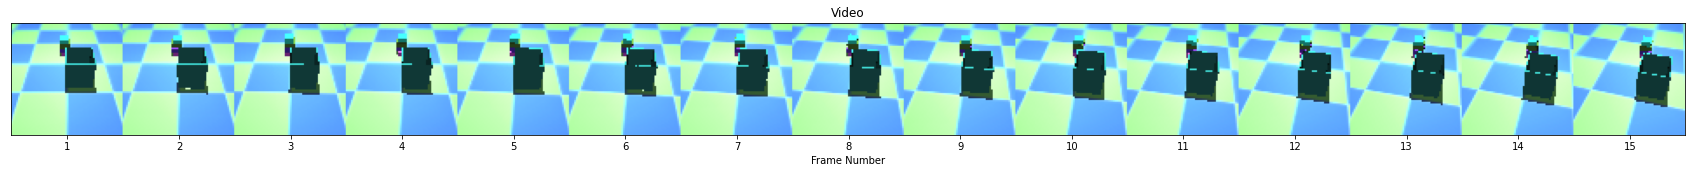

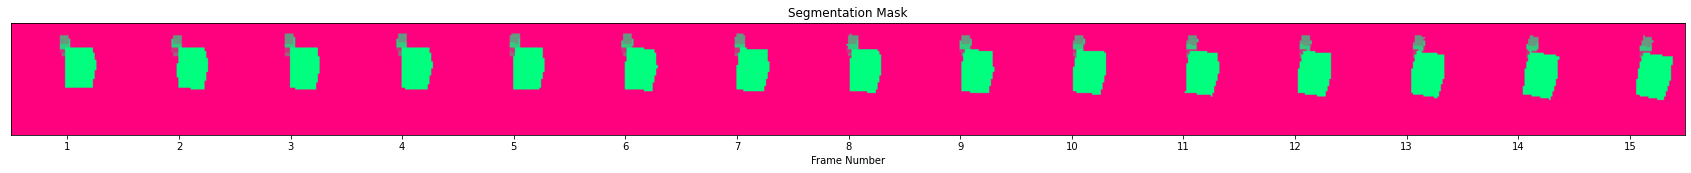

In [ ]:
#@title Load and Visualize Freeform Dataset
is_train = True #@param {type:"boolean"}

freeform_ds = make_freeform_tfrecord_dataset(is_train=True, shuffle=True)
freeform_generator = freeform_ds.as_numpy_iterator()

#_ = next(freeform_generator)
# Use second example as it is more illustrative
freeform_example = next(freeform_generator)

# Visualize
plot_video(freeform_example['image'], 'Video')
plot_video(colorize_mask(freeform_example['mask']/255.), 'Segmentation Mask')

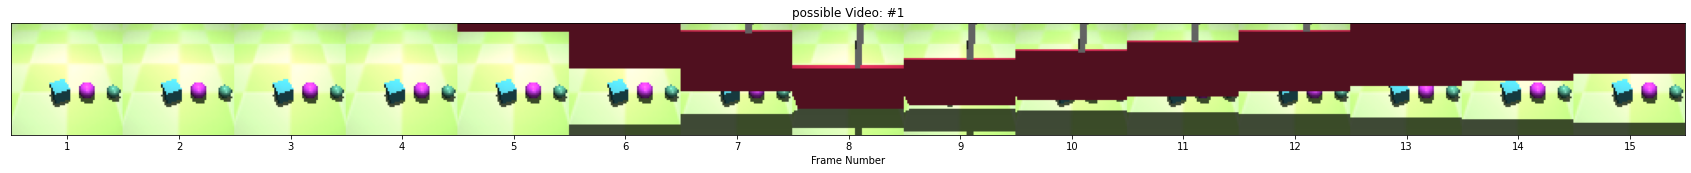

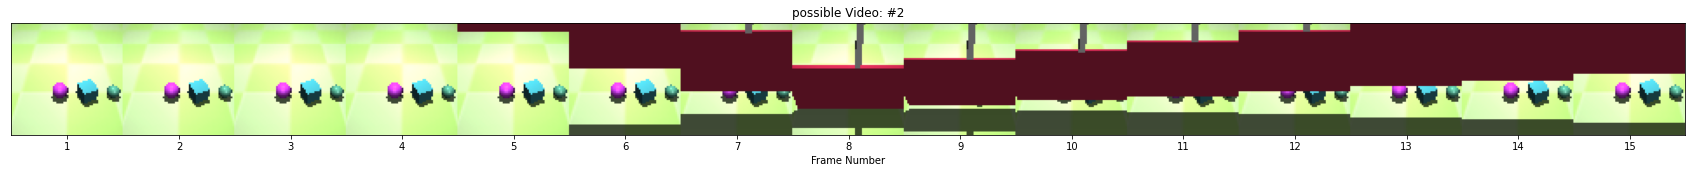

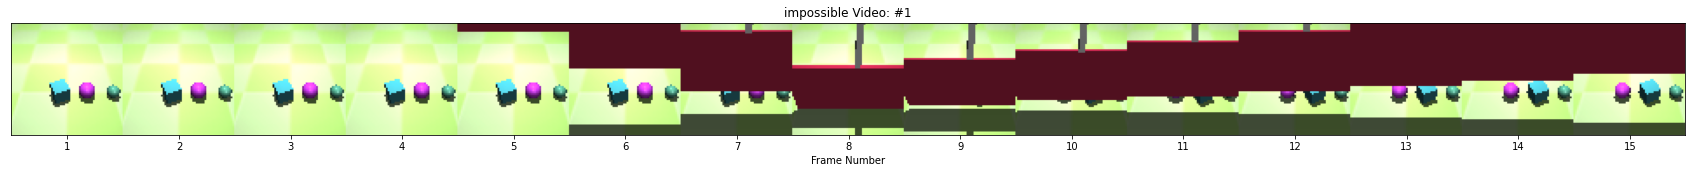

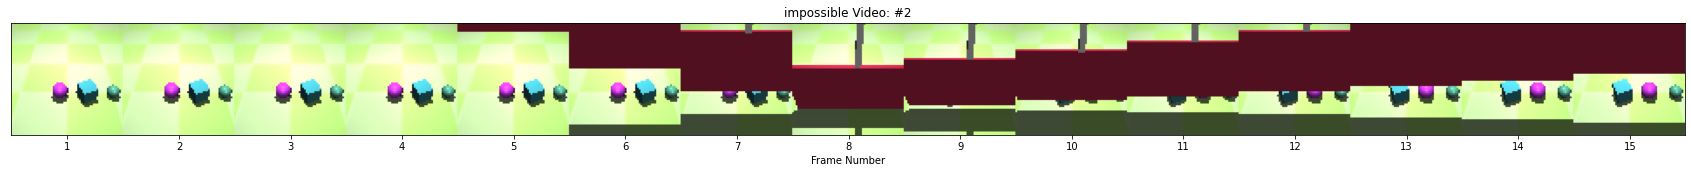

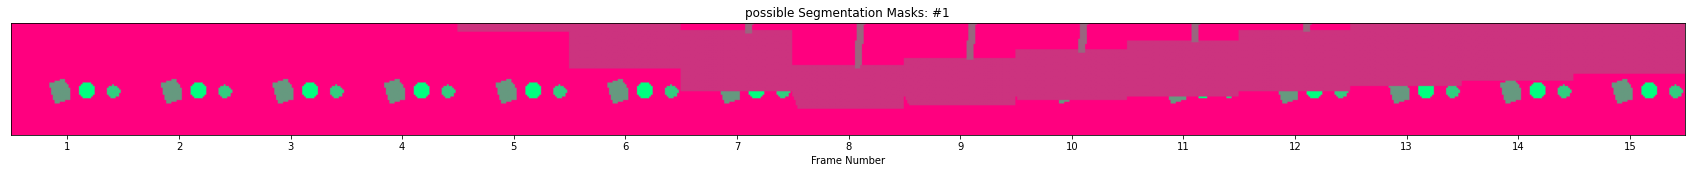

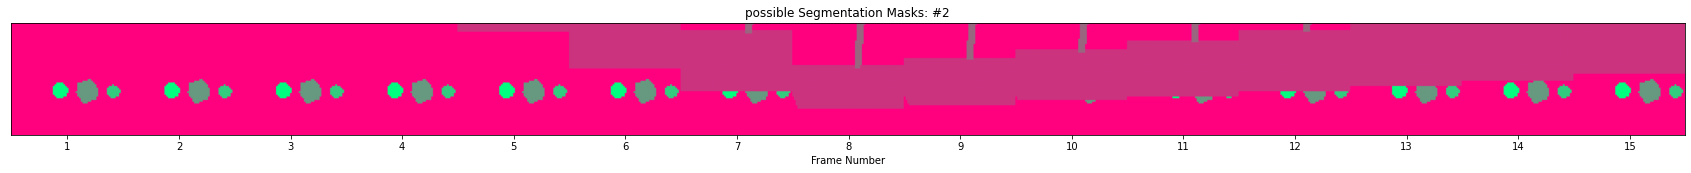

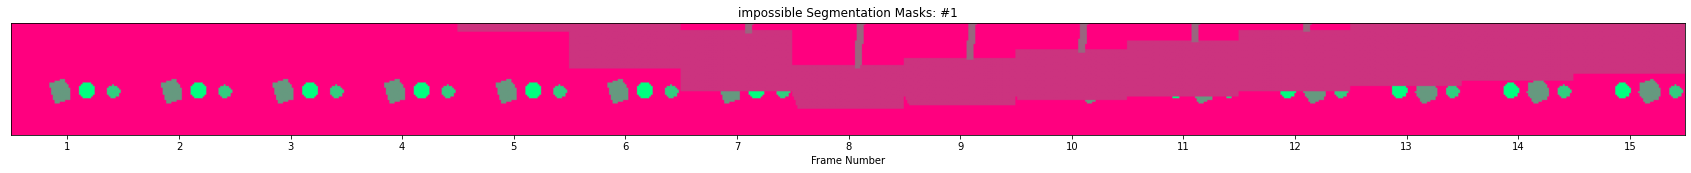

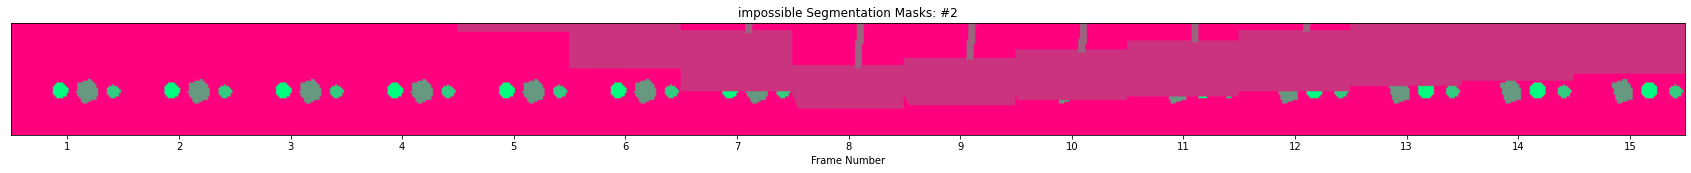

In [ ]:
#@title Load Probe Dataset
physical_concept = 'unchangeableness' #@param ['continuity', 'solidity', 'directional_inertia', 'unchangeableness', 'object_persistence']

probe_ds = make_probe_tfrecord_dataset(physical_concept, shuffle=True)
probe_generator = probe_ds.as_numpy_iterator()
probe_example = next(probe_generator)

# Visualize Probe Types Images Only
for probe_type in ('possible', 'impossible'):
  for i in range(2):
    image = probe_example[f'{probe_type}_image'][i]
    plot_video(image, f'{probe_type} Video: #{i+1}')


# Visualize Masks
for probe_type in ('possible', 'impossible'):
  for i in range(2):
    mask = probe_example[f'{probe_type}_mask'][i]
    plot_video(colorize_mask(mask/255.),
               f'{probe_type} Segmentation Masks: #{i+1}')